In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from scipy.linalg import block_diag
from scipy.special import gamma, kv
from scipy.stats import ks_1samp, uniform
from tqdm.auto import trange

%matplotlib inline
plt.style.use(["paper.mplstyle"])

In [2]:
def matern_kernel(xx, length, nu=5 / 2):
    dists = np.abs(np.subtract.outer(xx, xx)) / length
    if nu == 0.5:
        K = np.exp(-dists)
    elif nu == 1.5:
        K = dists * 3**0.5
        K = (1.0 + K) * np.exp(-K)
    elif nu == 2.5:
        K = dists * 5**0.5
        K = (1.0 + K + K**2 / 3.0) * np.exp(-K)
    elif nu == np.inf:
        K = np.exp(-(dists**2) / 2.0)
    else:  # general case; expensive to evaluate
        K = dists
        K[K == 0.0] += np.finfo(float).eps  # strict zeros result in nan
        tmp = (2 * nu)**0.5 * K
        K.fill((2 ** (1.0 - nu)) / gamma(nu))
        K *= tmp**nu
        K *= kv(nu, tmp)
    return K

def uncorrelated_kernel(xx, length=None):
    xx = xx**0
    K = np.add.outer(xx, xx) / 2
    np.fill_diagonal(K, 1)
    return K


def perfect_correlation(xx, length=None):
    xx = xx**0
    K = np.add.outer(xx, xx) * 0.00 / 2
    np.fill_diagonal(K, 1)
    return K


def blocked_kernel(xx, length):
    length = int(np.log10(length) * 2) + 4
    per_block = len(xx) // length
    return block_diag(*(np.ones((per_block, per_block)) for _ in range(length)), np.ones((len(xx) - per_block * length, len(xx) - per_block * length)))

In [3]:
n_samples = 100
var = 1
length = 1

all_quants = list()
all_pvals = list()

samples = np.linspace(-3, 3, n_samples)
true_ln_likelihood = - samples**2 / 2 - np.log(2 * np.pi) / 2
true_post = np.exp(true_ln_likelihood)
true_post /= np.trapz(true_post, samples)

for kernel_func in [blocked_kernel, matern_kernel, uncorrelated_kernel, perfect_correlation]:
    quants = list()
    pvals = list()

    kernel_ = kernel_func(np.ones(n_samples), length)

    for ll, length in enumerate([0.01, 0.1, 1]):
        uncertainties = (np.random.gamma(4, 0.25, n_samples) * var)**1
        if kernel_func == matern_kernel:
            kernel = kernel_func(samples, length) * np.outer(uncertainties, uncertainties)**0.5
        else:
            kernel = kernel_ * np.outer(uncertainties, uncertainties)**0.5
        covariance_ = kernel
        rel_cov_ = np.add.outer(covariance_.diagonal(), covariance_.diagonal()) - 2 * covariance_
        quant_ = np.trapz(np.trapz(np.outer(true_post, true_post) * rel_cov_, samples), samples)
        try:
            chol_ = np.linalg.cholesky(covariance_)
        except np.linalg.LinAlgError:
            chol_ = np.linalg.cholesky(covariance_ + 1e-10 * np.eye(n_samples))

        for _ in trange(400):
            target = 10**np.random.uniform(-2, 1.3)
            covariance = covariance_ * target / quant_
            rel_cov = rel_cov_ * target / quant_
            chol = chol_ * (target / quant_)**0.5
            quant = np.trapz(np.trapz(np.outer(true_post, true_post) * rel_cov, samples), samples)
            var_ = np.trapz(np.trapz(np.outer(true_post, true_post) * covariance, samples), samples)
            pvalues = list()
            for _ in range(100):
                truth = np.random.normal(0, 1)
                errors = chol @ np.random.normal(0, 1, n_samples)
                ln_likelihood = true_ln_likelihood + errors  # * abs(samples)**1 / 2
                post = np.exp(ln_likelihood)
                post /= np.trapz(post, samples)
                pvalues.append(np.trapz(post * (samples <= truth), samples))
            quants.append(np.log10(quant))
            pval = ks_1samp(pvalues, uniform(0, 1).cdf).pvalue
            pvals.append(pval)
    all_quants.append(quants)
    all_pvals.append(pvals)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

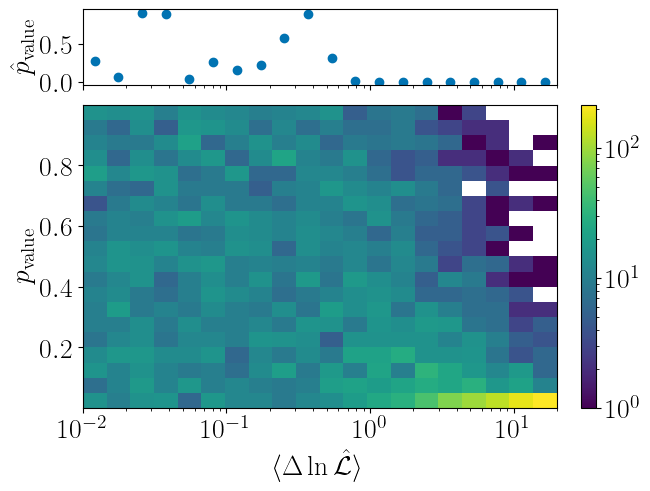

In [4]:
fig = plt.figure(layout="constrained")
axes = fig.subplots(
    nrows=2,
    ncols=1,
    height_ratios=[1, 4],
    sharex=True,
)

plt.sca(axes[1])

plt.hist2d(np.array(all_quants).flatten(), np.array(all_pvals).flatten(), bins=20, norm=mpl.colors.LogNorm())
plt.xlabel("$\\langle \\Delta \\ln \\hat{\\cal L} \\rangle$")
plt.ylabel("$p_{\\rm value}$")
plt.colorbar()
plt.xticks([-2, -1, 0, 1], [f"$10^{{{val}}}$" for val in [-2, -1, 0, 1]])
plt.xticks(np.log10([
    1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2,
    1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20
]), minor=True)

plt.sca(axes[0])

_pvalues = list()
_xvals = np.linspace(-2, np.log10(20), 21)
for lower in _xvals[:-1]:
    keep = (lower <= np.array(all_quants).flatten()) & (lower + 0.1 >= np.array(all_quants).flatten())
    _pvalues.append(ks_1samp(np.array(all_pvals).flatten()[keep], uniform(0, 1).cdf).pvalue)

_xvals = (_xvals[1:] + _xvals[:-1]) / 2
plt.scatter(_xvals, _pvalues)
plt.ylabel("$\hat{p}_{\\rm value}$")
plt.savefig("figure-1.pdf")
plt.show()
plt.close()